## Assignment 3

### Imports and inits

In [33]:
from sklearn.metrics import accuracy_score, f1_score  
from sklearn.metrics import roc_auc_score
import random
import datetime                                               # for timestamp 
import h2o                                                    # base h2o package for python
from h2o.estimators.glm import H2OGeneralizedLinearEstimator  # h2o elastic net models class
from h2o.grid.grid_search import H2OGridSearch                # grid search class and syntax for h2o models
from interpret import show                                    # basic visualizations from interpret package
from interpret.glassbox import ExplainableBoostingClassifier  # interpret ebm class
from interpret.perf import ROC                                # ROC measure for ebm
import itertools                                              # for cartesian product of parameters
import matplotlib.pyplot as plt                               # basic plotting
import numpy as np                                            # for basic array manipulation                            
import pandas as pd                                           # for dataframe manipulation
import seaborn as sns                                         # slightly better plotting  
import time                                                   # for timers
import xgboost as xgb                                             # base h2o package for python
import shap                                                      #get sharply values
import warnings                                                # remove warnings
warnings.filterwarnings("ignore", message="The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.")
# set numpy random seed for better reproducibility
SEED = 12345 
# enables display of images in notebook
from IPython.display import Image
from IPython.display import display
# set number of threads
NTHREAD = 4

In [34]:
from sklearn.metrics import accuracy_score, f1_score  
from sklearn.metrics import roc_auc_score
import random

In [35]:
def get_confusion_matrix(frame, y, yhat, by=None, level=None, cutoff=0.5, verbose=True):

    """ Creates confusion matrix from pandas dataframe of y and yhat values, can be sliced 
        by a variable and level.
    
        :param frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        :param y: Name of actual value column.
        :param yhat: Name of predicted value column.
        :param by: By variable to slice frame before creating confusion matrix, default None.
        :param level: Value of by variable to slice frame before creating confusion matrix, default None.
        :param cutoff: Cutoff threshold for confusion matrix, default 0.5. 
        :param verbose: Whether to print confusion matrix titles, default True. 
        :return: Confusion matrix as pandas dataframe. 
        
    """
    
    # determine levels of target (y) variable
    # sort for consistency
    level_list = list(frame[y].unique())
    level_list.sort(reverse=True) 

    # init confusion matrix
    cm_frame = pd.DataFrame(columns=['actual: ' +  str(i) for i in level_list], 
                            index=['predicted: ' + str(i) for i in level_list])
    
    # don't destroy original data
    frame_ = frame.copy(deep=True)
    
    # convert numeric predictions to binary decisions using cutoff
    dname = 'd_' + str(y)
    frame_[dname] = np.where(frame_[yhat] > cutoff , 1, 0)
    
    # slice frame
    if (by is not None) & (level is not None):
        frame_ = frame_[frame[by] == level]
    
    # calculate size of each confusion matrix value
    for i, lev_i in enumerate(level_list):
        for j, lev_j in enumerate(level_list):
            cm_frame.iat[j, i] = frame_[(frame_[y] == lev_i) & (frame_[dname] == lev_j)].shape[0]
            # i, j vs. j, i nasty little bug ... updated 8/30/19
    
    # output results
    if verbose:
        if by is None:
            print('Confusion matrix:')
        else:
            print('Confusion matrix by ' + by + '=' + str(level))
    
    return cm_frame

def air(cm_dict, reference_key, protected_key, verbose=True):

    """ Calculates the adverse impact ratio as a quotient between protected and 
        reference group acceptance rates: protected_prop/reference_prop. 
        Optionally prints intermediate values. ASSUMES 0 IS "POSITIVE" OUTCOME!

        :param cm_dict: Dictionary of demographic group confusion matrices. 
        :param reference_key: Name of reference group in cm_dict as a string.
        :param protected_key: Name of protected group in cm_dict as a string.
        :param verbose: Whether to print intermediate acceptance rates, default True. 
        :return: AIR.
        
    """

    eps = 1e-20 # numeric stability and divide by 0 protection
    
    # reference group summary
    reference_accepted = float(cm_dict[reference_key].iat[1,0] + cm_dict[reference_key].iat[1,1]) # predicted 0's
    reference_total = float(cm_dict[reference_key].sum().sum())
    reference_prop = reference_accepted/reference_total
    if verbose:
        print(reference_key.title() + ' proportion accepted: %.3f' % reference_prop)
    
    # protected group summary
    protected_accepted = float(cm_dict[protected_key].iat[1,0] + cm_dict[protected_key].iat[1,1]) # predicted 0's
    protected_total = float(cm_dict[protected_key].sum().sum())
    protected_prop = protected_accepted/protected_total
    if verbose:
        print(protected_key.title() + ' proportion accepted: %.3f' % protected_prop)

    # return adverse impact ratio
    if np.isclose(protected_accepted, 0.0):
        return np.nan
    else:
        return ((protected_prop + eps)/(reference_prop + eps))
    
def get_max_f1_frame(frame, y, yhat, res=0.01, air_reference=None, air_protected=None, verbose=False): 
    
    """ Utility function for finding max. F1. 
        Coupled to get_confusion_matrix() and air(). 
        Assumes 1 is the marker for class membership.
    
        :param frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        :param y: Known y values.
        :param yhat: Model scores.
        :param res: Resolution over which to search for max. F1, default 0.01.
        :param air_reference: Reference group for AIR calculation, optional.
        :param air_protected: Protected group for AIR calculation, optional.
        :return: Pandas DataFrame of cutoffs to select from.
    
    """
    
    do_air = all(v is not None for v in [air_reference, air_protected])
    
    # init frame to store f1 at different cutoffs
    if do_air:
        columns = ['cut', 'f1', 'acc', 'air']
    else:
        columns = ['cut', 'f1', 'acc']
    f1_frame = pd.DataFrame(columns=['cut', 'f1', 'acc'])
    
    # copy known y and score values into a temporary frame
    temp_df = frame[[y, yhat]].copy(deep=True)
    
    # find f1 at different cutoffs and store in acc_frame
    for cut in np.arange(0, 1 + res, res):
        temp_df['decision'] = np.where(temp_df.iloc[:, 1] > cut, 1, 0)
        f1 = f1_score(temp_df.iloc[:, 0], temp_df['decision'])
        acc = accuracy_score(temp_df.iloc[:, 0], temp_df['decision'])
        row_dict = {'cut': cut, 'f1': f1, 'acc': acc}
        if do_air:
            # conditionally calculate AIR  
            cm_ref = get_confusion_matrix(frame, y, yhat, by=air_reference, level=1, cutoff=cut, verbose=verbose)
            cm_pro = get_confusion_matrix(frame, y, yhat, by=air_protected, level=1, cutoff=cut, verbose=verbose)
            air_ = air({air_reference: cm_ref, air_protected: cm_pro}, air_reference, air_protected, verbose=verbose)
            row_dict['air'] = air_
            
        f1_frame = f1_frame.append(row_dict, ignore_index=True)
            
    del temp_df
        
    return f1_frame    

###  Start global timer

In [36]:
tic = time.time()

### Import data

In [37]:
data = pd.read_csv('hmda_train_preprocessed.csv')
test = pd.read_csv('hmda_test_preprocessed.csv')

### Assign basic modeling roles

In [38]:
y_name = 'high_priced'
x_names = ['term_360', 'conforming', 'debt_to_income_ratio_missing', 'loan_amount_std', 'loan_to_value_ratio_std', 'no_intro_rate_period_std',
           'intro_rate_period_std', 'property_value_std', 'income_std', 'debt_to_income_ratio_std']

## Fit interpretable models

### Split data into train and validation partitions

In [39]:
np.random.seed(SEED) # preserve exact reproducibility for this cell

split_ratio = 0.7 # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
valid = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

# benchmark - Train data rows = 112253, columns = 23
# benchmark - Validation data rows = 48085, columns = 23
print(type(valid))

Train data rows = 112253, columns = 23
Validation data rows = 48085, columns = 23
<class 'pandas.core.frame.DataFrame'>


## Best model - Regular XGBoost

### Define utility function for random grid search

- Since I cannot use ROC function, I use roc_auc_score function

In [40]:
def xgb_grid(train, valid, x_names, y_name, gs_params=None, n_models=None, seed=None,
             air_reference=None, air_protected=None, air_cut=None, verbose=False):

    # init returned frame
    do_air = all(v is not None for v in [air_reference, air_protected])
    if do_air: 
        columns = list(gs_params.keys()) + ['features', 'auc', 'air']
    else:
        columns = list(gs_params.keys()) + ['auc']
    xgb_grid_frame = pd.DataFrame(columns=columns)
    
    # cartesian product of gs_params
    keys, values = zip(*gs_params.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # preserve exact reproducibility for this function
    np.random.seed(seed) 
    
    # select randomly from cartesian product space
    selected_experiments = np.random.choice(len(experiments), n_models)

    # set global params for seed, etc.
    params = {'n_jobs': -1,
              'random_state': seed}

    # init grid search loop
    best_candidate = None
    best_score = 0

    # grid search loop
    for i, exp in enumerate(selected_experiments):

        params.update(experiments[exp])  # override global params with current grid run params

        print('Grid search run %d/%d:' % (int(i + 1), int(n_models)))
        print('Training with parameters:', params)
        
        # train 
        xgb_model = xgb.XGBClassifier(**params)
        
        # conditionally select random features 
        features = x_names
        if do_air:
            n_features = random.randrange(len(x_names)) + 1
            features = random.sample(x_names, n_features)
        candidate = xgb_model.fit(train[features], train[y_name]) 

        # calculate AUC
        xgb_preds = xgb_model.predict_proba(valid[features])[:, 1]
        candidate_best_score = roc_auc_score(valid[y_name], xgb_preds)
    
        # compose values to add to xgb_grid_frame
        row_dict = params.copy()
        row_dict['auc'] = candidate_best_score
        if do_air:
            # collect random feature set
            row_dict['features'] = features
            # conditionally calculate AIR  
            valid_phat = valid.copy(deep=True)
            valid_phat['phat'] = candidate.predict_proba(valid[features])[:, 1]
            cm_ref = get_confusion_matrix(valid_phat, y_name, 'phat', by=air_reference, level=1, cutoff=air_cut, verbose=verbose)
            cm_pro = get_confusion_matrix(valid_phat, y_name, 'phat', by=air_protected, level=1, cutoff=air_cut, verbose=verbose)
            air_ = air({air_reference: cm_ref, air_protected: cm_pro}, air_reference, air_protected, verbose=verbose)
            row_dict['air'] = air_
            del valid_phat

        # append run to xgb_grid_frame
        xgb_grid_frame = xgb_grid_frame.append(row_dict, ignore_index=True)
    
        # determine if current model is better than previous best
        if candidate_best_score > best_score:
            best_score = candidate_best_score
            best_xgb_model = candidate
            print('Grid search new best score discovered at iteration %d/%d: %.4f.' %
                             (int(i + 1), int(n_models), candidate_best_score))

        print('---------- ----------')
        
        del row_dict
        del xgb_model
            
    return best_xgb_model, xgb_grid_frame

### Fit Regular XGBoost with random grid search

In [41]:
# dictionary of hyperparameter value lists for grid search
gs_params = {'max_depth': [3, 6, 9],
             'learning_rate': [0.001, 0.01, 0.05],
             'subsample': [0.6, 0.8, 1.0],
             'colsample_bytree': [0.6, 0.8, 1.0],
             'min_child_weight': [1, 5, 10],
             'gamma': [0, 0.1, 0.3],
             'reg_alpha': [0, 0.1, 0.5],
             'reg_lambda': [0.5, 1.0, 1.5]}

# start local timer
xgb_tic = time.time()

# XGBoost grid search
best_xgb_model, xgb_grid_frame = xgb_grid(train, valid, x_names, y_name, gs_params=gs_params, n_models=10, 
                                         seed=SEED)

# end local timer
xgb_toc = time.time() - xgb_tic
print('XGBoost training completed in %.2f s.' % (xgb_toc))


Grid search run 1/10:
Training with parameters: {'n_jobs': -1, 'random_state': 12345, 'max_depth': 9, 'learning_rate': 0.001, 'subsample': 0.6, 'colsample_bytree': 1.0, 'min_child_weight': 5, 'gamma': 0.1, 'reg_alpha': 0.5, 'reg_lambda': 0.5}
Grid search new best score discovered at iteration 1/10: 0.8186.
---------- ----------
Grid search run 2/10:
Training with parameters: {'n_jobs': -1, 'random_state': 12345, 'max_depth': 6, 'learning_rate': 0.01, 'subsample': 1.0, 'colsample_bytree': 0.8, 'min_child_weight': 10, 'gamma': 0.3, 'reg_alpha': 0, 'reg_lambda': 1.5}
---------- ----------
Grid search run 3/10:
Training with parameters: {'n_jobs': -1, 'random_state': 12345, 'max_depth': 3, 'learning_rate': 0.05, 'subsample': 1.0, 'colsample_bytree': 1.0, 'min_child_weight': 10, 'gamma': 0.1, 'reg_alpha': 0.5, 'reg_lambda': 1.5}
---------- ----------
Grid search run 4/10:
Training with parameters: {'n_jobs': -1, 'random_state': 12345, 'max_depth': 6, 'learning_rate': 0.01, 'subsample': 1.0,

### Basic AUC assessment

In [42]:
# Predict probabilities using the best model on the validation data
xgb_preds = best_xgb_model.predict_proba(valid[x_names])[:, 1]

# Calculate the AUC
auc = roc_auc_score(valid[y_name], xgb_preds)
print("Validation AUC: %.4f" % auc)

Validation AUC: 0.8246


### Score validation data with model

In [43]:
best_xgb_phat = pd.DataFrame(best_xgb_model.predict_proba(valid[x_names])[:, 1], columns=['phat']) 
best_xgb_phat = pd.concat([valid.reset_index(drop=True), best_xgb_phat], axis=1)
best_xgb_phat.head()

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced,phat
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,...,0,-0.514393,0.333922,0.244394,-0.215304,-0.535932,-0.040307,0.854601,0,0.196983
1,6,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0,-0.426448,0.355249,0.244394,-0.215304,-0.474263,-0.020904,1.037419,0,0.291481
2,8,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,0.277109,0.142995,0.244394,-0.215304,0.111598,-0.019865,0.031916,0,0.030087
3,10,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,-0.382476,-0.240432,0.244394,-0.215304,-0.320089,-0.028181,0.946010,0,0.014811
4,11,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,...,0,0.101220,-0.266529,0.244394,-0.215304,0.111598,0.016515,-1.156406,0,0.007766


## Find out AIR

#### Investigate Best Model (XGBoost) for Discrimination

In [44]:
#Find optimal cutoff based on F1
f1_frame = get_max_f1_frame(best_xgb_phat, y_name, 'phat')

print(f1_frame)
print()

max_f1 = f1_frame['f1'].max()
best_cut = f1_frame.loc[int(f1_frame['f1'].idxmax()), 'cut'] #idxmax() returns the index of the maximum value
acc = f1_frame.loc[int(f1_frame['f1'].idxmax()), 'acc']

print('Best F1: %.4f achieved at cutoff: %.2f with accuracy: %.4f.' % (max_f1, best_cut, acc))

      cut        f1       acc
0    0.00  0.173860  0.095206
1    0.01  0.211378  0.294562
2    0.02  0.249493  0.438723
3    0.03  0.269600  0.500135
4    0.04  0.286237  0.545409
..    ...       ...       ...
96   0.96  0.000000  0.904794
97   0.97  0.000000  0.904794
98   0.98  0.000000  0.904794
99   0.99  0.000000  0.904794
100  1.00  0.000000  0.904794

[101 rows x 3 columns]

Best F1: 0.3669 achieved at cutoff: 0.17 with accuracy: 0.7657.


In [45]:
## Find confusion matrices for demographic groups
demographic_group_names = ['black', 'asian', 'hispanic','white', 'male', 'female']
cm_dict = {}

for name in demographic_group_names:
    cm_dict[name] = get_confusion_matrix(best_xgb_phat, y_name, 'phat', by=name, level=1, cutoff=best_cut)
    print(cm_dict[name])
    print()

Confusion matrix by black=1
             actual: 1 actual: 0
predicted: 1       517      1092
predicted: 0       147      1436

Confusion matrix by asian=1
             actual: 1 actual: 0
predicted: 1       103       238
predicted: 0        45      2864

Confusion matrix by hispanic=1
             actual: 1 actual: 0
predicted: 1       737      1480
predicted: 0       280      2505

Confusion matrix by white=1
             actual: 1 actual: 0
predicted: 1      2229      7330
predicted: 0       936     24030

Confusion matrix by male=1
             actual: 1 actual: 0
predicted: 1      1195      3841
predicted: 0       469     10327

Confusion matrix by female=1
             actual: 1 actual: 0
predicted: 1       949      2650
predicted: 0       291      6142



In [46]:
print('Adverse impact ratio for Asian people vs. White people: %.3f' % air(cm_dict, 'white', 'asian'))

White proportion accepted: 0.723
Asian proportion accepted: 0.895
Adverse impact ratio for Asian people vs. White people: 1.238


In [48]:
print('Adverse impact ratio for black people vs. White people: %.3f' % air(cm_dict, 'white', 'black'))

White proportion accepted: 0.723
Black proportion accepted: 0.496
Adverse impact ratio for black people vs. White people: 0.686


In [49]:
print('Adverse impact ratio for white people vs. hispanic people: %.3f' % air(cm_dict, 'white', 'hispanic'))

White proportion accepted: 0.723
Hispanic proportion accepted: 0.557
Adverse impact ratio for white people vs. hispanic people: 0.770


In [50]:
print('Adverse impact ratio for Females vs. Males: %.3f' % air(cm_dict, 'male', 'female'))

Male proportion accepted: 0.682
Female proportion accepted: 0.641
Adverse impact ratio for Females vs. Males: 0.940


In [51]:
print('Adverse impact ratio for Females vs. Males: %.3f' % air(cm_dict, 'female', 'male'))

Female proportion accepted: 0.641
Male proportion accepted: 0.682
Adverse impact ratio for Females vs. Males: 1.063


## Simple way

In [52]:
f1_frame = get_max_f1_frame(best_xgb_phat, y_name, 'phat', air_reference='white', air_protected='black')
# print highest quality cutoffs above four fifths rule cutoff
f1_frame[f1_frame['air'] > 0.8].sort_values(by='f1', ascending=False).head()

,cut,f1,acc,air
22,0.22,0.357481,0.836207,0.817626
23,0.23,0.345448,0.847187,0.844581
24,0.24,0.326639,0.857752,0.877528
25,0.25,0.312292,0.866549,0.887757
26,0.26,0.298898,0.872975,0.903112


In [53]:
# calculate new confusion matrics for each group
rem_cm_dict = {}
for name in demographic_group_names:
    rem_cm_dict[name] = get_confusion_matrix(best_xgb_phat, y_name, 'phat', by=name, level=1, cutoff=0.26, verbose=False)

# calculate AIR for each group
print('Adverse impact ratio for Asian people vs. White people: %.3f' % air(rem_cm_dict, 'white', 'asian', verbose=False))
print('Adverse impact ratio for Black people vs. White people: %.3f' % air(rem_cm_dict, 'white', 'black', verbose=False))
print('Adverse impact ratio for hispanic people vs. White people: %.3f' % air(rem_cm_dict, 'white', 'hispanic', verbose=False))
print('Adverse impact ratio for Females vs. Males: %.3f' % air(rem_cm_dict, 'male', 'female', verbose=False))

Adverse impact ratio for Asian people vs. White people: 1.055
Adverse impact ratio for Black people vs. White people: 0.903
Adverse impact ratio for hispanic people vs. White people: 0.933
Adverse impact ratio for Females vs. Males: 0.983


#### More sophisticated remdiation: Model selection via quality and fairness

In [54]:
# start local timer
xgb2_tic = time.time()

# new grid search that also considers AIR and fairness
best_xgb2_model, xgb_grid_frame = xgb_grid(train, valid, x_names, y_name, gs_params=gs_params, n_models=300, 
                                         seed=SEED,air_reference='white', air_protected='black', air_cut=0.17);

# end local timer
xgb2_toc = time.time() - xgb2_tic
print('xgb training completed in %.2f s.' % (xgb2_toc))

Grid search run 1/300:
Training with parameters: {'n_jobs': -1, 'random_state': 12345, 'max_depth': 9, 'learning_rate': 0.001, 'subsample': 0.6, 'colsample_bytree': 1.0, 'min_child_weight': 5, 'gamma': 0.1, 'reg_alpha': 0.5, 'reg_lambda': 0.5}
Grid search new best score discovered at iteration 1/300: 0.8186.
---------- ----------
Grid search run 2/300:
Training with parameters: {'n_jobs': -1, 'random_state': 12345, 'max_depth': 6, 'learning_rate': 0.01, 'subsample': 1.0, 'colsample_bytree': 0.8, 'min_child_weight': 10, 'gamma': 0.3, 'reg_alpha': 0, 'reg_lambda': 1.5}
---------- ----------
Grid search run 3/300:
Training with parameters: {'n_jobs': -1, 'random_state': 12345, 'max_depth': 3, 'learning_rate': 0.05, 'subsample': 1.0, 'colsample_bytree': 1.0, 'min_child_weight': 10, 'gamma': 0.1, 'reg_alpha': 0.5, 'reg_lambda': 1.5}
---------- ----------
Grid search run 4/300:
Training with parameters: {'n_jobs': -1, 'random_state': 12345, 'max_depth': 6, 'learning_rate': 0.01, 'subsample':

---------- ----------
Grid search run 32/300:
Training with parameters: {'n_jobs': -1, 'random_state': 12345, 'max_depth': 3, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 1.0, 'min_child_weight': 1, 'gamma': 0.3, 'reg_alpha': 0, 'reg_lambda': 1.5}
---------- ----------
Grid search run 33/300:
Training with parameters: {'n_jobs': -1, 'random_state': 12345, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.6, 'colsample_bytree': 0.8, 'min_child_weight': 5, 'gamma': 0.3, 'reg_alpha': 0, 'reg_lambda': 0.5}
---------- ----------
Grid search run 34/300:
Training with parameters: {'n_jobs': -1, 'random_state': 12345, 'max_depth': 3, 'learning_rate': 0.05, 'subsample': 1.0, 'colsample_bytree': 0.8, 'min_child_weight': 10, 'gamma': 0, 'reg_alpha': 0.1, 'reg_lambda': 1.5}
---------- ----------
Grid search run 35/300:
Training with parameters: {'n_jobs': -1, 'random_state': 12345, 'max_depth': 6, 'learning_rate': 0.001, 'subsample': 0.8, 'colsample_bytree': 1.0, 'min_child_wei

---------- ----------
Grid search run 63/300:
Training with parameters: {'n_jobs': -1, 'random_state': 12345, 'max_depth': 9, 'learning_rate': 0.05, 'subsample': 0.6, 'colsample_bytree': 0.6, 'min_child_weight': 5, 'gamma': 0, 'reg_alpha': 0.5, 'reg_lambda': 1.5}
Grid search new best score discovered at iteration 63/300: 0.8250.
---------- ----------
Grid search run 64/300:
Training with parameters: {'n_jobs': -1, 'random_state': 12345, 'max_depth': 9, 'learning_rate': 0.01, 'subsample': 0.6, 'colsample_bytree': 0.6, 'min_child_weight': 1, 'gamma': 0.3, 'reg_alpha': 0.1, 'reg_lambda': 1.0}
---------- ----------
Grid search run 65/300:
Training with parameters: {'n_jobs': -1, 'random_state': 12345, 'max_depth': 9, 'learning_rate': 0.01, 'subsample': 1.0, 'colsample_bytree': 0.8, 'min_child_weight': 5, 'gamma': 0.1, 'reg_alpha': 0, 'reg_lambda': 0.5}
---------- ----------
Grid search run 66/300:
Training with parameters: {'n_jobs': -1, 'random_state': 12345, 'max_depth': 6, 'learning_rat

---------- ----------
Grid search run 94/300:
Training with parameters: {'n_jobs': -1, 'random_state': 12345, 'max_depth': 6, 'learning_rate': 0.01, 'subsample': 0.8, 'colsample_bytree': 1.0, 'min_child_weight': 1, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1.5}
---------- ----------
Grid search run 95/300:
Training with parameters: {'n_jobs': -1, 'random_state': 12345, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.6, 'colsample_bytree': 1.0, 'min_child_weight': 1, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1.0}
---------- ----------
Grid search run 96/300:
Training with parameters: {'n_jobs': -1, 'random_state': 12345, 'max_depth': 6, 'learning_rate': 0.01, 'subsample': 0.8, 'colsample_bytree': 0.8, 'min_child_weight': 10, 'gamma': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 1.5}
---------- ----------
Grid search run 97/300:
Training with parameters: {'n_jobs': -1, 'random_state': 12345, 'max_depth': 9, 'learning_rate': 0.01, 'subsample': 0.8, 'colsample_bytree': 0.6, 'min_child_weight

---------- ----------
Grid search run 125/300:
Training with parameters: {'n_jobs': -1, 'random_state': 12345, 'max_depth': 6, 'learning_rate': 0.001, 'subsample': 0.8, 'colsample_bytree': 1.0, 'min_child_weight': 10, 'gamma': 0.1, 'reg_alpha': 0.5, 'reg_lambda': 1.0}
---------- ----------
Grid search run 126/300:
Training with parameters: {'n_jobs': -1, 'random_state': 12345, 'max_depth': 6, 'learning_rate': 0.001, 'subsample': 0.6, 'colsample_bytree': 1.0, 'min_child_weight': 1, 'gamma': 0.3, 'reg_alpha': 0, 'reg_lambda': 1.5}
---------- ----------
Grid search run 127/300:
Training with parameters: {'n_jobs': -1, 'random_state': 12345, 'max_depth': 6, 'learning_rate': 0.01, 'subsample': 0.8, 'colsample_bytree': 1.0, 'min_child_weight': 5, 'gamma': 0.3, 'reg_alpha': 0.5, 'reg_lambda': 1.5}
---------- ----------
Grid search run 128/300:
Training with parameters: {'n_jobs': -1, 'random_state': 12345, 'max_depth': 3, 'learning_rate': 0.001, 'subsample': 0.8, 'colsample_bytree': 1.0, 'min

---------- ----------
Grid search run 156/300:
Training with parameters: {'n_jobs': -1, 'random_state': 12345, 'max_depth': 3, 'learning_rate': 0.001, 'subsample': 1.0, 'colsample_bytree': 0.6, 'min_child_weight': 5, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1.0}
---------- ----------
Grid search run 157/300:
Training with parameters: {'n_jobs': -1, 'random_state': 12345, 'max_depth': 9, 'learning_rate': 0.05, 'subsample': 0.6, 'colsample_bytree': 0.8, 'min_child_weight': 10, 'gamma': 0, 'reg_alpha': 0.1, 'reg_lambda': 1.0}
---------- ----------
Grid search run 158/300:
Training with parameters: {'n_jobs': -1, 'random_state': 12345, 'max_depth': 3, 'learning_rate': 0.05, 'subsample': 0.6, 'colsample_bytree': 0.6, 'min_child_weight': 5, 'gamma': 0.1, 'reg_alpha': 0, 'reg_lambda': 1.5}
---------- ----------
Grid search run 159/300:
Training with parameters: {'n_jobs': -1, 'random_state': 12345, 'max_depth': 9, 'learning_rate': 0.05, 'subsample': 1.0, 'colsample_bytree': 0.6, 'min_child_w

---------- ----------
Grid search run 187/300:
Training with parameters: {'n_jobs': -1, 'random_state': 12345, 'max_depth': 9, 'learning_rate': 0.01, 'subsample': 1.0, 'colsample_bytree': 0.8, 'min_child_weight': 1, 'gamma': 0.3, 'reg_alpha': 0.1, 'reg_lambda': 0.5}
---------- ----------
Grid search run 188/300:
Training with parameters: {'n_jobs': -1, 'random_state': 12345, 'max_depth': 6, 'learning_rate': 0.01, 'subsample': 0.8, 'colsample_bytree': 0.8, 'min_child_weight': 10, 'gamma': 0.3, 'reg_alpha': 0, 'reg_lambda': 1.5}
---------- ----------
Grid search run 189/300:
Training with parameters: {'n_jobs': -1, 'random_state': 12345, 'max_depth': 9, 'learning_rate': 0.001, 'subsample': 0.6, 'colsample_bytree': 1.0, 'min_child_weight': 5, 'gamma': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 1.0}
---------- ----------
Grid search run 190/300:
Training with parameters: {'n_jobs': -1, 'random_state': 12345, 'max_depth': 9, 'learning_rate': 0.05, 'subsample': 0.6, 'colsample_bytree': 0.6, 'min_c

---------- ----------
Grid search run 218/300:
Training with parameters: {'n_jobs': -1, 'random_state': 12345, 'max_depth': 6, 'learning_rate': 0.01, 'subsample': 0.8, 'colsample_bytree': 1.0, 'min_child_weight': 1, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 0.5}
---------- ----------
Grid search run 219/300:
Training with parameters: {'n_jobs': -1, 'random_state': 12345, 'max_depth': 6, 'learning_rate': 0.001, 'subsample': 0.6, 'colsample_bytree': 1.0, 'min_child_weight': 10, 'gamma': 0.3, 'reg_alpha': 0.1, 'reg_lambda': 1.5}
---------- ----------
Grid search run 220/300:
Training with parameters: {'n_jobs': -1, 'random_state': 12345, 'max_depth': 6, 'learning_rate': 0.001, 'subsample': 1.0, 'colsample_bytree': 0.6, 'min_child_weight': 10, 'gamma': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 0.5}
---------- ----------
Grid search run 221/300:
Training with parameters: {'n_jobs': -1, 'random_state': 12345, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 1.0, 'colsample_bytree': 0.8, 'min_c

---------- ----------
Grid search run 249/300:
Training with parameters: {'n_jobs': -1, 'random_state': 12345, 'max_depth': 9, 'learning_rate': 0.01, 'subsample': 1.0, 'colsample_bytree': 1.0, 'min_child_weight': 10, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 0.5}
---------- ----------
Grid search run 250/300:
Training with parameters: {'n_jobs': -1, 'random_state': 12345, 'max_depth': 3, 'learning_rate': 0.001, 'subsample': 1.0, 'colsample_bytree': 0.6, 'min_child_weight': 5, 'gamma': 0, 'reg_alpha': 0.5, 'reg_lambda': 0.5}
---------- ----------
Grid search run 251/300:
Training with parameters: {'n_jobs': -1, 'random_state': 12345, 'max_depth': 9, 'learning_rate': 0.05, 'subsample': 0.6, 'colsample_bytree': 1.0, 'min_child_weight': 5, 'gamma': 0.3, 'reg_alpha': 0, 'reg_lambda': 1.5}
---------- ----------
Grid search run 252/300:
Training with parameters: {'n_jobs': -1, 'random_state': 12345, 'max_depth': 9, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'min_child_w

---------- ----------
Grid search run 280/300:
Training with parameters: {'n_jobs': -1, 'random_state': 12345, 'max_depth': 9, 'learning_rate': 0.05, 'subsample': 1.0, 'colsample_bytree': 1.0, 'min_child_weight': 1, 'gamma': 0.3, 'reg_alpha': 0, 'reg_lambda': 0.5}
---------- ----------
Grid search run 281/300:
Training with parameters: {'n_jobs': -1, 'random_state': 12345, 'max_depth': 3, 'learning_rate': 0.001, 'subsample': 1.0, 'colsample_bytree': 0.8, 'min_child_weight': 5, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 0.5}
---------- ----------
Grid search run 282/300:
Training with parameters: {'n_jobs': -1, 'random_state': 12345, 'max_depth': 3, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'min_child_weight': 1, 'gamma': 0.3, 'reg_alpha': 0.5, 'reg_lambda': 1.0}
---------- ----------
Grid search run 283/300:
Training with parameters: {'n_jobs': -1, 'random_state': 12345, 'max_depth': 3, 'learning_rate': 0.05, 'subsample': 1.0, 'colsample_bytree': 0.6, 'min_child_

### Visualization of AIR vs. AUC for XGB

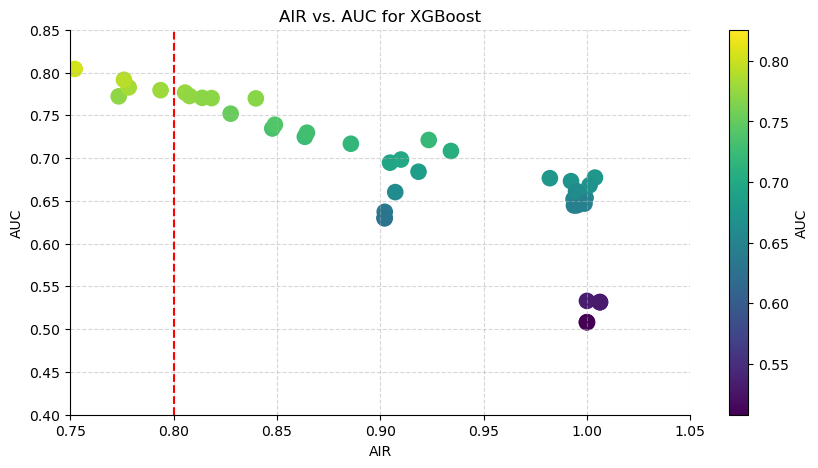

In [56]:
# Set up figure and axes
fig, ax = plt.subplots(figsize=(10, 5))

# Plot scatter points with increased dot size
scatter = ax.scatter(xgb_grid_frame['air'], xgb_grid_frame['auc'], c=xgb_grid_frame['auc'], cmap='viridis', s=120)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('AUC')

# Add vertical line
ax.axvline(x=0.8, color='r', linestyle='--')

# Set plot limits and labels
ax.set_ylim([0.4, 0.85])
ax.set_xlim([0.75, 1.05])
ax.set_xlabel('AIR')
ax.set_ylabel('AUC')
ax.set_title('AIR vs. AUC for XGBoost')

# Add gridlines
ax.grid(True, linestyle='--', alpha=0.5)

# Remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show the plot
plt.show()

### Retrain most accurate model above 0.8 AIR

In [71]:
# extract new params dict from xgb_grid_frame
rem_params = xgb_grid_frame.loc[xgb_grid_frame['air'] > 0.8].sort_values(by='auc', ascending=False).iloc[0, :].to_dict()

# extract features from dict then delete from dict 
rem_x_names = rem_params['features']
del rem_params['features']

# record and delete other extraneous information
print('Best AUC: %.4f above 0.8 AIR (%.4f).' % (rem_params['auc'], rem_params['air']))
del rem_params['auc']
del rem_params['air']

# reset some parameters to integers
rem_params['random_state'] = int(rem_params['random_state'])
rem_params['n_jobs'] = int(rem_params['n_jobs'])

# Fit the remediated XGBoost model
rem_xgb = xgb.XGBClassifier(**rem_params)
rem_xgb.fit(train[rem_x_names], train[y_name])

# Make predictions on the validation dataset using the remediated XGBoost model
rem_xgb_preds = rem_xgb.predict_proba(valid[rem_x_names])[:, 1]

# Calculate the AUC using sklearn's roc_auc_score function
rem_auc = roc_auc_score(valid[y_name], rem_xgb_preds)
print('Remediated XGB retrained with AUC: %.4f.' % rem_auc)

Best AUC: 0.7765 above 0.8 AIR (0.8055).
Remediated XGB retrained with AUC: 0.7765.


- I tried to use air_cut=0.16 or less but it shows a relatively lower AUC but I decide to use air_cut = 0.17
- Thanks to the new set of features and hyperparameters leads to a increase in AIR.

In [58]:
# create a frame with remediated xgb predictions
best_xgb_phat2 = pd.DataFrame(rem_xgb.predict_proba(valid[rem_x_names])[:, 1], columns=['phat']) 
best_xgb_phat2 = pd.concat([valid.reset_index(drop=True), best_xgb_phat2], axis=1)

# calculate new confusion matrices for each group
rem_cm_dict2 = {}
for name in demographic_group_names:
    rem_cm_dict2[name] = get_confusion_matrix(best_xgb_phat2, y_name, 'phat', by=name, level=1, cutoff=0.17, verbose=False)

# calculate AIR for each group
print('Adverse impact ratio for Asian people vs. White people: %.3f' % air(rem_cm_dict2, 'white', 'asian', verbose=False))
print('Adverse impact ratio for Black people vs. White people: %.3f' % air(rem_cm_dict2, 'white', 'black', verbose=False))
print('Adverse impact ratio for Black people vs. White people: %.3f' % air(rem_cm_dict2, 'white', 'hispanic', verbose=False))
print('Adverse impact ratio for Females vs. Males: %.3f' % air(rem_cm_dict2, 'male', 'female', verbose=False))

Adverse impact ratio for Asian people vs. White people: 1.148
Adverse impact ratio for Black people vs. White people: 0.806
Adverse impact ratio for Black people vs. White people: 0.875
Adverse impact ratio for Females vs. Males: 0.945


In [59]:
rem_params

{'max_depth': 9,
 'learning_rate': 0.05,
 'subsample': 1.0,
 'colsample_bytree': 0.6,
 'min_child_weight': 5,
 'gamma': 0.1,
 'reg_alpha': 0.1,
 'reg_lambda': 1.0,
 'n_jobs': -1,
 'random_state': 12345}

In [60]:
rem_x_names

['term_360',
 'no_intro_rate_period_std',
 'property_value_std',
 'intro_rate_period_std',
 'income_std',
 'debt_to_income_ratio_std',
 'conforming']

- After remediating discovered discrimination, I have not reduced any other group’s AIR score below 0.8.

In [61]:
#best_xgb_phat2_submit = pd.DataFrame(rem_xgb.predict_proba(test[x_names])[:, 1], columns=['phat'])
best_xgb_phat2_submit = pd.DataFrame(rem_xgb.predict_proba(test[rem_x_names])[:, 1], columns=['phat'])
best_xgb_phat2_submit.to_csv('Joonkyu_Hong__xgb' + str(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.csv'), 
                        index=False)

In [30]:
test[x_names]

,term_360,conforming,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std
0,1,1,0,-0.514393,-0.039293,0.244394,-0.215304,-0.474263,-0.017786,0.854601
1,1,1,0,-0.162614,0.126830,0.244394,-0.215304,-0.227585,-0.015014,-0.425131
2,1,1,0,-0.646310,0.552520,0.244394,-0.215304,-0.659271,-0.033378,-0.425131
3,1,0,0,3.662982,0.133614,0.244394,-0.215304,2.763389,0.025177,0.306144
4,1,1,0,-0.338504,0.552520,0.244394,-0.215304,-0.443428,-0.027834,0.306144
...,...,...,...,...,...,...,...,...,...,...
19826,1,1,0,-0.690283,0.273620,0.244394,-0.215304,-0.659271,-0.040307,0.580372
19827,1,1,0,-0.294531,0.380433,0.244394,-0.215304,-0.381758,-0.006006,0.397554
19828,1,1,0,-0.162614,0.552520,0.244394,-0.215304,-0.320089,-0.029913,1.585876
19829,1,0,0,3.135314,-0.826437,-4.091747,4.610857,3.595928,0.016169,0.123326


In [31]:
valid[rem_x_names]

,property_value_std,debt_to_income_ratio_missing,debt_to_income_ratio_std,income_std,intro_rate_period_std
0,-0.535932,0,0.854601,-0.040307,-0.215304
6,-0.474263,0,1.037419,-0.020904,-0.215304
8,0.111598,0,0.031916,-0.019865,-0.215304
10,-0.320089,0,0.946010,-0.028181,-0.215304
11,0.111598,0,-1.156406,0.016515,-0.215304
...,...,...,...,...,...
160322,-0.566767,0,-1.156406,-0.024023,-0.215304
160325,-0.227585,0,0.031916,-0.022983,-0.215304
160327,-0.258419,0,-1.156406,0.013744,-0.215304
160328,0.450780,0,0.306144,-0.023330,-0.215304


In [70]:
# Make predictions on the train dataset using the remediated XGBoost model
train_rem_xgb_preds = rem_xgb.predict_proba(train[rem_x_names])[:, 1]

# Calculate the AUC using sklearn's roc_auc_score function
train_rem_auc = roc_auc_score(train[y_name], train_rem_xgb_preds)
print('Remediated XGB retrained with AUC: %.4f.' % rem_auc)

Remediated XGB retrained with AUC: 0.7765.


### End timer

In [32]:
toc = time.time() - tic
print('All tasks completed in %.2f s.' % (toc))

All tasks completed in 1119.25 s.
